In [1]:
from data_loader import load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
train = load_data()

## Dataset shape

In [3]:
train.shape

(1460, 81)

## Variables

In [4]:
print(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

At the first glance, in column space we see **Id** column which doesn't take part in model.  
Column **SalePrice** is dependent variable; model objective is to predict future sales price for new unseen data.  
So far we can say that dataset contains **1460 examples** with **79 features and 1 target variable per example**.

# Variable categories

In [5]:
col_dtypes = train.dtypes
numeric_feats = col_dtypes[col_dtypes != 'object'].axes[0].tolist()
categoric_feats = col_dtypes[col_dtypes == 'object'].axes[0].tolist()
print(f'Numeric var space:   {len(numeric_feats)}')
print(f'Categoric var space: {len(categoric_feats)}')

Numeric var space:   38
Categoric var space: 43


Numeric variable are both continuous and discrete containing **1 continuous dependent variable and other 37 numeric idependent variables**.   

Remaining **43 variables are categorical**. Since models accepts only numerical data types, we have to perform appropriate encoding on these variables, however some encoding methods lead to widen feature space too much and during this exploration I want to figure out right trade-off for encoding strategy.  

Data examples must be considered in terms of *missing values* and *outliers*. Right strategy to manage with this obstacles will be evaluated during process of exploration.

Statistical analysis conducted in the next notebooks gives information about problems presented above. Moreover it will give me information about other desirable data preparation techniques which finally increase performance of models.

# Numercial varibles

### Missing values

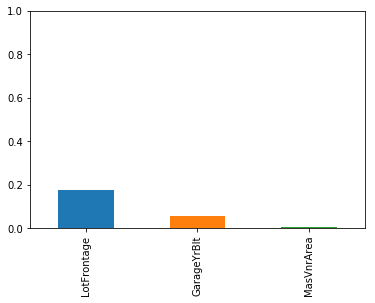

In [6]:
nan_numeric_info = train[numeric_feats].isnull().sum()
nan_numeric_feats = nan_numeric_info[nan_numeric_info>0]
nan_numeric_feats.apply(lambda x: x/train.shape[0]).sort_values(ascending=False).plot(kind='bar', ylim=(0, 1))

In [7]:
MasVnrArea_null_idx = train['MasVnrArea'].isnull()
train[MasVnrArea_null_idx]['MasVnrType'].unique()

array([nan], dtype=object)

1. LotFrontage is strong correlated with LotArea (look at notebook 1.2.1). Since imputing with mean or mode or zero gives bad results (such imputed values doesn't follow correlation):
    - it seems feasible to impute with regression (predict missing) 
    - we can also drop this feature (due to belief, that LotFrontage is reduntant to LotArea beacuse of correlation with LotArea)
2. GarageYrBlt missing values are at random (look at notebook 1.2.1)
    - GarageYrBlt may be set to 0, since it will vanish its term in regression  
    - GarageYrBlt may be deleted
3. MasVnrArea is set to NaN only when there is no masonry type specified

### Numeric discrete
Since there are many features with finite and small set of unique integers we can assume that are discrete values.

In [8]:
numeric_discrete = ['BsmtHalfBath', 'HalfBath','FullBath','BsmtFullBath','Fireplaces','KitchenAbvGr','GarageCars','YrSold', \
                    'BedroomAbvGr', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'MoSold', 'MSSubClass', 'YearRemodAdd', \
                   'GarageYrBlt', 'YearBuilt']
print(numeric_discrete)

['BsmtHalfBath', 'HalfBath', 'FullBath', 'BsmtFullBath', 'Fireplaces', 'KitchenAbvGr', 'GarageCars', 'YrSold', 'BedroomAbvGr', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'MoSold', 'MSSubClass', 'YearRemodAdd', 'GarageYrBlt', 'YearBuilt']


### Numeric continuous
Remaining variables which aren't qualified as discrete are continuous

In [9]:
numeric_continuous = [x for x in numeric_feats if x not in numeric_discrete]
print(numeric_continuous)

['Id', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']


In [10]:
#check if no numerical feature missed
num_feats_set = set(numeric_discrete)|set(numeric_continuous)
num_feats_set.issubset(set(numeric_feats)) & num_feats_set.issuperset(set(numeric_feats))

True

# Categorical variables

### Missing values

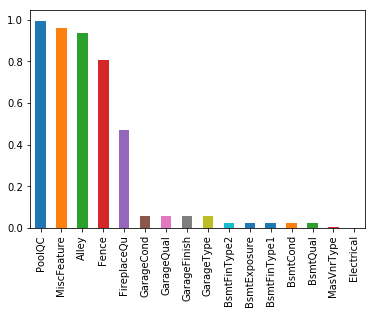

In [11]:
nan_categoric_info = train[categoric_feats].isnull().sum()
nan_categoric_feats = nan_categoric_info[nan_categoric_info>0]
if not nan_categoric_feats.empty:
    nan_categoric_feats.apply(lambda x: x/train.shape[0]).sort_values(ascending=False).plot(kind='bar')
else:
    print("No missing value in such range")

1. Most of missing features presented above  are missing when there is no such feature in the house (like no pool, no basement, no garage, no masonry)
    - they could be replaced with value like "None"
2. Missing in electrical is random 
    - it could be replace e.g. with mode or we could do some more insight into this example (for purpose of delete this example, when classified as outlier)

### Oridnal features
Ordinal features can be distinguished from nominal via empirical analysis of the data, e.g. using own experience, some domain knowledge. The main objective of such work is to don't break feture into many binary (indicator) features.
For ordinal features is feasible for replacing them with specified value with correct order.  
**NOTES**  
- Oridnal categorical features list may be reduce in order to ensure more accurate mapping from categorical to numerical (using dummies instead)

In [12]:
ordinal_cat_feats = ['Alley', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'ExterCond' , \
                    'ExterQual', 'Fence', 'FireplaceQu', 'Functional', 'GarageCond','GarageQual', 'HeatingQC', 'KitchenQual',\
                     'PavedDrive','Utilities','LotShape', 'LandSlope', 'Electrical', 'PoolQC', 'GarageFinish']
print(ordinal_cat_feats)

['Alley', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional', 'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual', 'PavedDrive', 'Utilities', 'LotShape', 'LandSlope', 'Electrical', 'PoolQC', 'GarageFinish']


c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


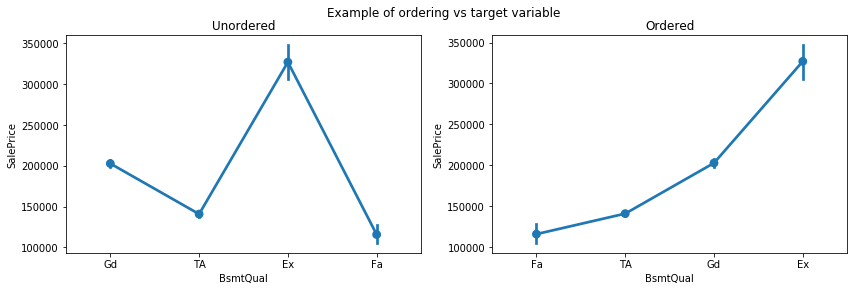

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
sns.pointplot(train['BsmtQual'],train['SalePrice'], ax=ax[0])
sns.pointplot(train['BsmtQual'],train['SalePrice'], ax=ax[1], order=['Fa', 'TA', 'Gd', 'Ex'])
ax[0].set_title('Unordered')
ax[1].set_title('Ordered')
fig.suptitle('Example of ordering vs target variable')
plt.show()

1. Handcrafted mappers ensures that there is no order violation during mapping, but this technique suffers from many hard-to-tackle problems
- Since it's quite reasonable to handle mapping with own-designed mappers (for keep correct order), it's intractable to perform mapping during working with model (validation using pipelines have to do all this job "on the fly" to prevent data leakage)
- Mapping should always keep the rule of not encoding values which doesn't exist in train set (or train subset in cross-validation), and such handcrafted mappers, did in advance, doesn't follow this rule
- As shown on plots above, ordering values linearly (e.g. a-1, b-2, c-3 etc.) doesn't take into account that there may be some different spacing between values, so that features may not be ideally linearly distributed and only setting to dummies takes advantage of this problem, yet it leads to much increase in feature space, linear order could work well enough 
    - most trivial solution is to use e.g. sklearn.LabelEncoder (could be bad, beacuse in fact it orders at random)
    - ordering with respect to SalePrice correaltion may be applied
- When dealing with missing ordinal variable values, it should be set to 0 (if there is no other imputation strategy)

### Nominal features
Nominal features are these categoricals which order isn't known and hence decompoisng nominals to dummies is the only proper way to prepare them for model

In [14]:
nominal_cat_feats = [x for x in categoric_feats if x not in ordinal_cat_feats]
print(nominal_cat_feats)

['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']


In [15]:
#check if no categorical feature missed
cat_feats_set = set(nominal_cat_feats)|set(ordinal_cat_feats)
cat_feats_set.issubset(set(categoric_feats)) & cat_feats_set.issuperset(set(categoric_feats))

True